## Searching for Hardware Aware Neural Networks on ImageNet for FPGA in MobilenetV3 Search Space

We need to estimate the accuracy of samples in our search space because it requires significant amount of time to train each subnet for evaluating its perfomace. This slows down the searching process. Accuracy peredictory MLP that was trained on the (arch, accu) dataset in our search space is used to speed up the search process as we won't have to train the network at all. The search is perfomed on the Imagenet Dataset. 

We have also build a latency table by manualy deploying all the unique blocks of our search space on ULTRA96v2 FPGA board this will be utilized to estimate latency of our networks.


#### IDEA
Introducing a new parameter by combining the accuracy, model size(params), mac ops , and latency called efficient_arthemetic_intensity which is defined   

defination: paper link

Trying to do three things maximizing the mac operations perfomed by model which represents the learning capacity
of model while minimizing the number of paramters which is the size of model and also minimizing the latency 
on target hardware thus finding a model that has performs maximum calculation while being smaller and faster.


### Overview
Every architecutre configuration is represented in dictionary format.  
Accuracy predictor predicts accuracy based on this configuration.  
Latency Estimator also uses this configuration to estimate the latency.   


## Preperation

In [1]:
# For kaggle
# !rm -r /kaggle/working/Evolutionary-Neural-Architectural-Search-for-FPGAs /kaggle/working/ofa /kaggle/working/viz /kaggle/working/search_space_blocks /kaggle/working/blocks /kaggle/working/figures

!pip install thop 
! pip install gdown
!pip install shutil
!pip install graphviz
! pip install torch-summary 
! git clone --branch for_kaggle https://github.com/amitpant7/Evolutionary-Neural-Architectural-Search-for-FPGAs.git
! mv -f /kaggle/working/Evolutionary-Neural-Architectural-Search-for-FPGAs/* /kaggle/working
! rm -r Evolutionary-Neural-Architectural-Search-for-FPGAs

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


Cloning into 'Evolutionary-Neural-Architectural-Search-for-FPGAs'...
error: RPC failed; curl 92 HTTP/2 stream 0 was not closed cleanly: CANCEL (err 8)
error: 6062 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output
'mv' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
print('Installing PyTorch...')
! pip install torch 
print('Installing torchvision...')
! pip install torchvision
print('Installing numpy...')
! pip install numpy 
# thop is a package for FLOPs computing.
print('Installing thop (FLOPs counter) ...')
! pip install thop 
# ofa is a package containing training code, pretrained specialized models and inference code for the once-for-all networks.
# print('Installing OFA...')
# ! pip install ofa 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip install tqdm 
print('Installing matplotlib...')
! pip install matplotlib 
! pip install torch-summary 

print('All required packages have been successfully installed!')

Installing PyTorch...
Installing torchvision...
Installing numpy...
Installing thop (FLOPs counter) ...
Installing tqdm (progress bar) ...
Installing matplotlib...
All required packages have been successfully installed!


In [3]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
import time
import random
import shutil
import math
from PIL import Image
import copy
from matplotlib import pyplot as plt
from torchsummary import summary

from ofa.model_zoo import ofa_net
from ofa.utils import download_url

from ofa.accuracy_predictor import AccuracyPredictor
from ofa.flops_table import ArthIntTable

from ofa.new_evolution_finder import EvolutionFinder
from ofa.imagenet_eval_helper import evaluate_ofa_subnet, evaluate_ofa_specialized
from ofa.imagenet_classification.elastic_nn.networks.ofa_mbv3 import OFAMobileNetV3

from ofa.utils.arch_visualization_helper import draw_arch

from tqdm import tqdm

# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

Successfully imported all packages and configured random seed to 1!


In [4]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using CPU.


## 2. Datasets
Now, let's build the ImageNet dataset and the corresponding dataloader. Notice that **if you are not in kaggle it will be skipped** since it will be very slow.


We will only use subset of ImageNet validation set which will contains 10,000 images for testing.

In [5]:
batch_size=32

#I will use a susbset of imagenetval of 10k images 
if cuda_available:
    # path to the ImageNet dataset
    # link --> https://www.kaggle.com/datasets/titericz/imagenet1k-val
    
    imagenet_data_path = '/kaggle/input/imagenet1k-subset-100k-train-and-10k-val/imagenet_subval'

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')
    
    
  
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])
    
    val_data = datasets.ImageFolder(
            root=os.path.join(imagenet_data_path),
            transform=build_val_transform(224)
        )
    

    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,  
        shuffle = True,
        num_workers=4,  
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready. Size : {}'.format(len(val_loader)*batch_size))
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.
Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.


In [6]:
from ofa.utils.common_tools import *
def evaluate_sub(net, data_loader = val_loader ,device="cuda:0"):
    if "cuda" in device:
        net = torch.nn.DataParallel(net).to(device)
    else:
        net = net.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    net.eval()
    net = net.to(device)
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        with tqdm(total=len(data_loader), desc="Validate") as t:
            for i, (images, labels) in enumerate(data_loader):
                images, labels = images.to(device), labels.to(device)
                # compute output
                output = net(images)
                loss = criterion(output, labels)
                # measure accuracy and record loss
                acc1, acc5 = accuracy(output, labels, topk=(1, 5))

                losses.update(loss.item(), images.size(0))
                top1.update(acc1[0].item(), images.size(0))
                top5.update(acc5[0].item(), images.size(0))
                t.set_postfix(
                    {
                        "loss": losses.avg,
                        "top1": top1.avg,
                        "top5": top5.avg,
                        "img_size": images.size(2),
                    }
                )
                t.update(1)

    print(
        "Results: loss=%.5f,\t top1=%.1f,\t top5=%.1f"
        % (losses.avg, top1.avg, top5.avg)
    )
    return top1.avg

NameError: name 'val_loader' is not defined

#### Some visualization of architectures and encoding 


In [5]:
cfg = {'ks': [7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5, 7, 5, 3, 7, 7],
   'e': [6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4],
   'd': [4, 4, 4, 4, 4], 
   'r': [224]}

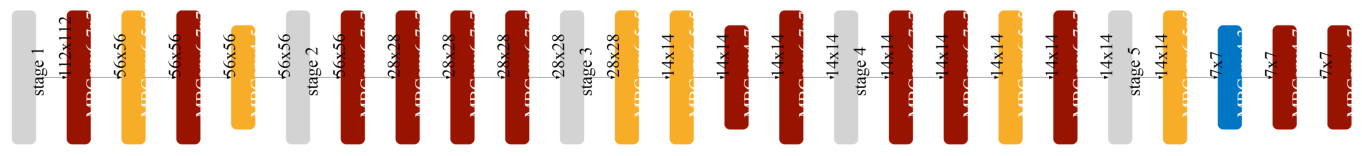

In [6]:
# visualization of network
def visualize_subnet(cfg):
    image_size = 224
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], image_size, out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

visualize_subnet(cfg)

## 3. Predictors 

In [7]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)

print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


In [8]:
class ComputeLatencyIndex():
    """Predictor class that predicts the efficiency of architecture given the accuracy predictor, 
    arthemetic intensity precictor and latency predictor. A new parameter is calculated and we call is compute_latency_index(cli)
    
    ref: [paper]

    """
    
    def __init__(self, accuracy_predictor, ai_predictor, latency_predictor, weights = [0.5, 0.5]):
        self.ai = ai_predictor
        self.lat = latency_predictor
        self.acc = accuracy_predictor    #expects list of samples
        self.wts = weights
        
    
    def predict_efficiency(self, sample):   #Computes CLI of latency.
        arth_int = 1/self.ai.predict_efficiency(sample)  #actualy returns 1/arth_intensity
        latency = self.lat.predict_efficiency(sample)
        acc = self.acc.predict_accuracy([sample]).item()
        
        cli =  self.wts[1]*arth_int/latency + self.wts[0]*acc
        
        return cli  #inverse in order to make it the minimization problem
        
    

In [9]:
from fpga_utils.latency_estimation import LatencyTable  

arthemetic_intensity_lookup = ArthIntTable(pred_type='arthemetic_intensity', 
                                  device='cuda:0' if cuda_available else 'cpu',batch_size=1, 
                                  )

latency_estimator = LatencyTable()

cli_predictor = ComputeLatencyIndex(accuracy_predictor, arthemetic_intensity_lookup, latency_estimator, weights= [0.5, 0.5])


Building the arthemetic_intensity lookup table (resolution=224)...
Built the arthemetic_intensity lookup table (resolution=224)!


In [10]:
# Predicting the parameters.
print(1/arthemetic_intensity_lookup.predict_efficiency(cfg), ' ops/byete')
print(latency_estimator.predict_efficiency(cfg), ' ms')
print(cli_predictor.predict_efficiency(cfg))    

30.673169815330247  ops/byete
37.835  ms
0.8294807285204135


## 4. Searching the networks

In [19]:
#  Hyper-parameters for the evolutionary search process

P = 1000  # The size of population in each generation
N = 5  # How many generations of population to be searched
r = 0.3  # The ratio of networks that are used as parents for next generation

params = {
    'constraint_type': 'cli', # Efficient Arthemetic intensity constrained search
    'efficiency_constraint': 0.3,  # latency constraint , suggested range [10, 45]
    'mutate_prob': 0.3, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.4, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': cli_predictor, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}


finder = EvolutionFinder(**params)




result_lis = []
result_valids = []
info = []

st = time.time()

best_valids, best_info = finder.run_evolution_search()
ed = time.time()


acc = accuracy_predictor.predict_accuracy([best_info[-1]])
print('Found best architecture at CLI = %.2f in %.2f seconds! It achieves %.2f%s predicted accuracy' % (best_info[0], ed-st, acc * 100, '%'))
result_lis.append(best_info)
result_valids.append(best_valids)
info.append(ed-st)

Generate random population...
Start Evolution...


Searching with cli: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

Found best architecture at CLI = 1.27 in 5.34 seconds! It achieves 80.18% predicted accuracy


[(1.2667596493019508, {'wid': None, 'ks': [3, 3, 3, 5, 3, 3, 3, 7, 5, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 5], 'e': [6, 4, 4, 3, 6, 4, 6, 3, 3, 3, 3, 4, 6, 3, 3, 6, 3, 3, 4, 6], 'd': [3, 3, 2, 3, 2], 'r': [224]})]
{'wid': None, 'ks': [3, 3, 3, 5, 3, 3, 3, 7, 5, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 5], 'e': [6, 4, 4, 3, 6, 4, 6, 3, 3, 3, 3, 4, 6, 3, 3, 6, 3, 3, 4, 6], 'd': [3, 3, 2, 3, 2], 'r': [224]}


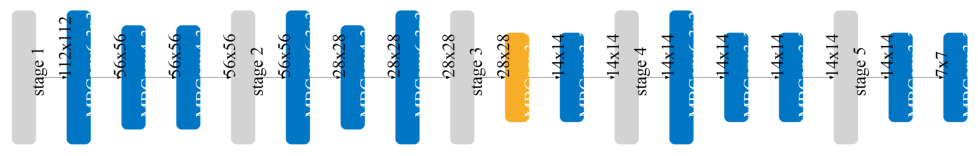

Latency: 12.32ms, AI: 21.34ops/byte, Accuracy: 80.18%, CLI: 1.267


In [23]:
print(result_lis)


for arch in result_lis:
    _, cfg= result_lis[-1]
    print(cfg)
    visualize_subnet(cfg)
    
    latency = latency_estimator.predict_efficiency(cfg)
    cli = cli_predictor.predict_efficiency(cfg)
    accuracy = accuracy_predictor.predict_accuracy([cfg]).item() * 100
    print(f"Latency: {latency:.2f}ms, AI: {ai:.2f}ops/byte, Accuracy: {accuracy:.2f}%, CLI: {cli:.3f}")
    